In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats
from scipy.stats import iqr
import matplotlib.pyplot as plt

data_path = '../../data/generalize_test/'
model_path = './model/'

def norm_err(y_test, p_test):
    """
    Calculates the normalized error between a true and predicted reference interval as proposed in CA-125 paper submitted to Sci. Reports
    
    Arguments:
        y_test:   true RI
        p_test:   predicted RI
        
    Returns:
        normalized error
    """
    return np.mean([np.abs(i-j) for i,j in zip([-1, 1], (p_test-y_test.mean())/y_test.std())])


In [2]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [3]:
# load data
test_x = pickle.load(open(data_path+'x_test.pkl', 'rb'))
test_y = pickle.load(open(data_path+'y_test.pkl', 'rb'))

test_x = [np.array(i) for i in test_x]


In [4]:
# scale data

data_means = [i.mean() for i in test_x]
data_std = [i.std() for i in test_x]
data_scaled = [(i-i.mean())/i.std() for i in test_x]


In [5]:
# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))


In [6]:
# extract features
features = np.array([extract_features(i) for i in data_scaled])
features.shape


(1000, 100, 1)

In [7]:
# predict
test_p = model.predict(features)
test_p = scalery.inverse_transform(test_p)


32/32 [==============================] - 2s 22ms/step


In [8]:
len(np.where(np.isnan(test_p))[0])


0

In [9]:
# standardize target RIs
test_y_scaled = [(i-j)/k for i,j,k in zip(test_y, data_means, data_std)]


In [10]:
# get central 95% RIs
test_p_ris = [i[[1, -3]] for i in test_p]
test_y_ris = [i[[1, -2]] for i in test_y_scaled]


In [11]:
errors = [norm_err(i, j) for i,j in zip(test_y_ris, test_p_ris)]
errors = np.array(errors)


In [12]:
np.mean(errors)


0.11422729781270027

In [13]:
np.median(errors)


0.08761964738368988

In [14]:
error_threshold = 0.2
len(np.where(errors<=error_threshold)[0])/len(errors)


0.847

In [15]:
error_threshold = 0.1
len(np.where(errors<=error_threshold)[0])/len(errors)


0.569

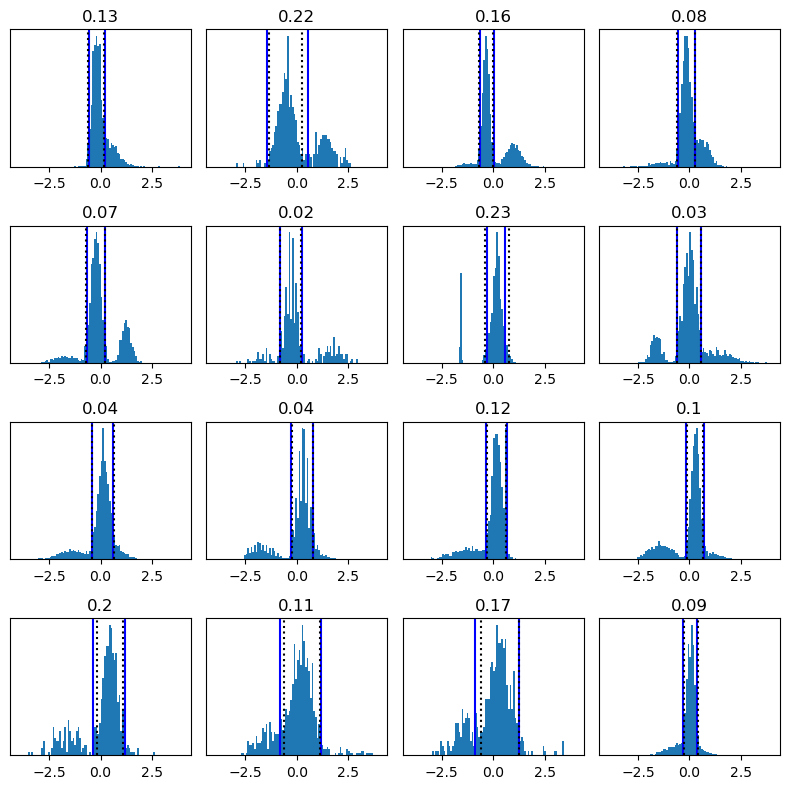

In [16]:
nr = 4
nc = 4
idx = np.linspace(0, 999, nr*nc).astype(int)
plt.figure(figsize=(8, 8))
for c,i in enumerate(idx):
    plt.subplot(nr, nc, c+1)
    plt.hist(data_scaled[i], np.linspace(-4, 4, 101), density=True);
    for j in test_p_ris[i]:
        plt.axvline(j, c='b')
    for j in test_y_ris[i]:
        plt.axvline(j, c='k', linestyle=':')
    plt.yticks([])
    plt.title(round(errors[i], 2))
plt.tight_layout()


In [17]:
idx[-2]

932

In [18]:
test_p[idx[-2]][-1]


0.6996109

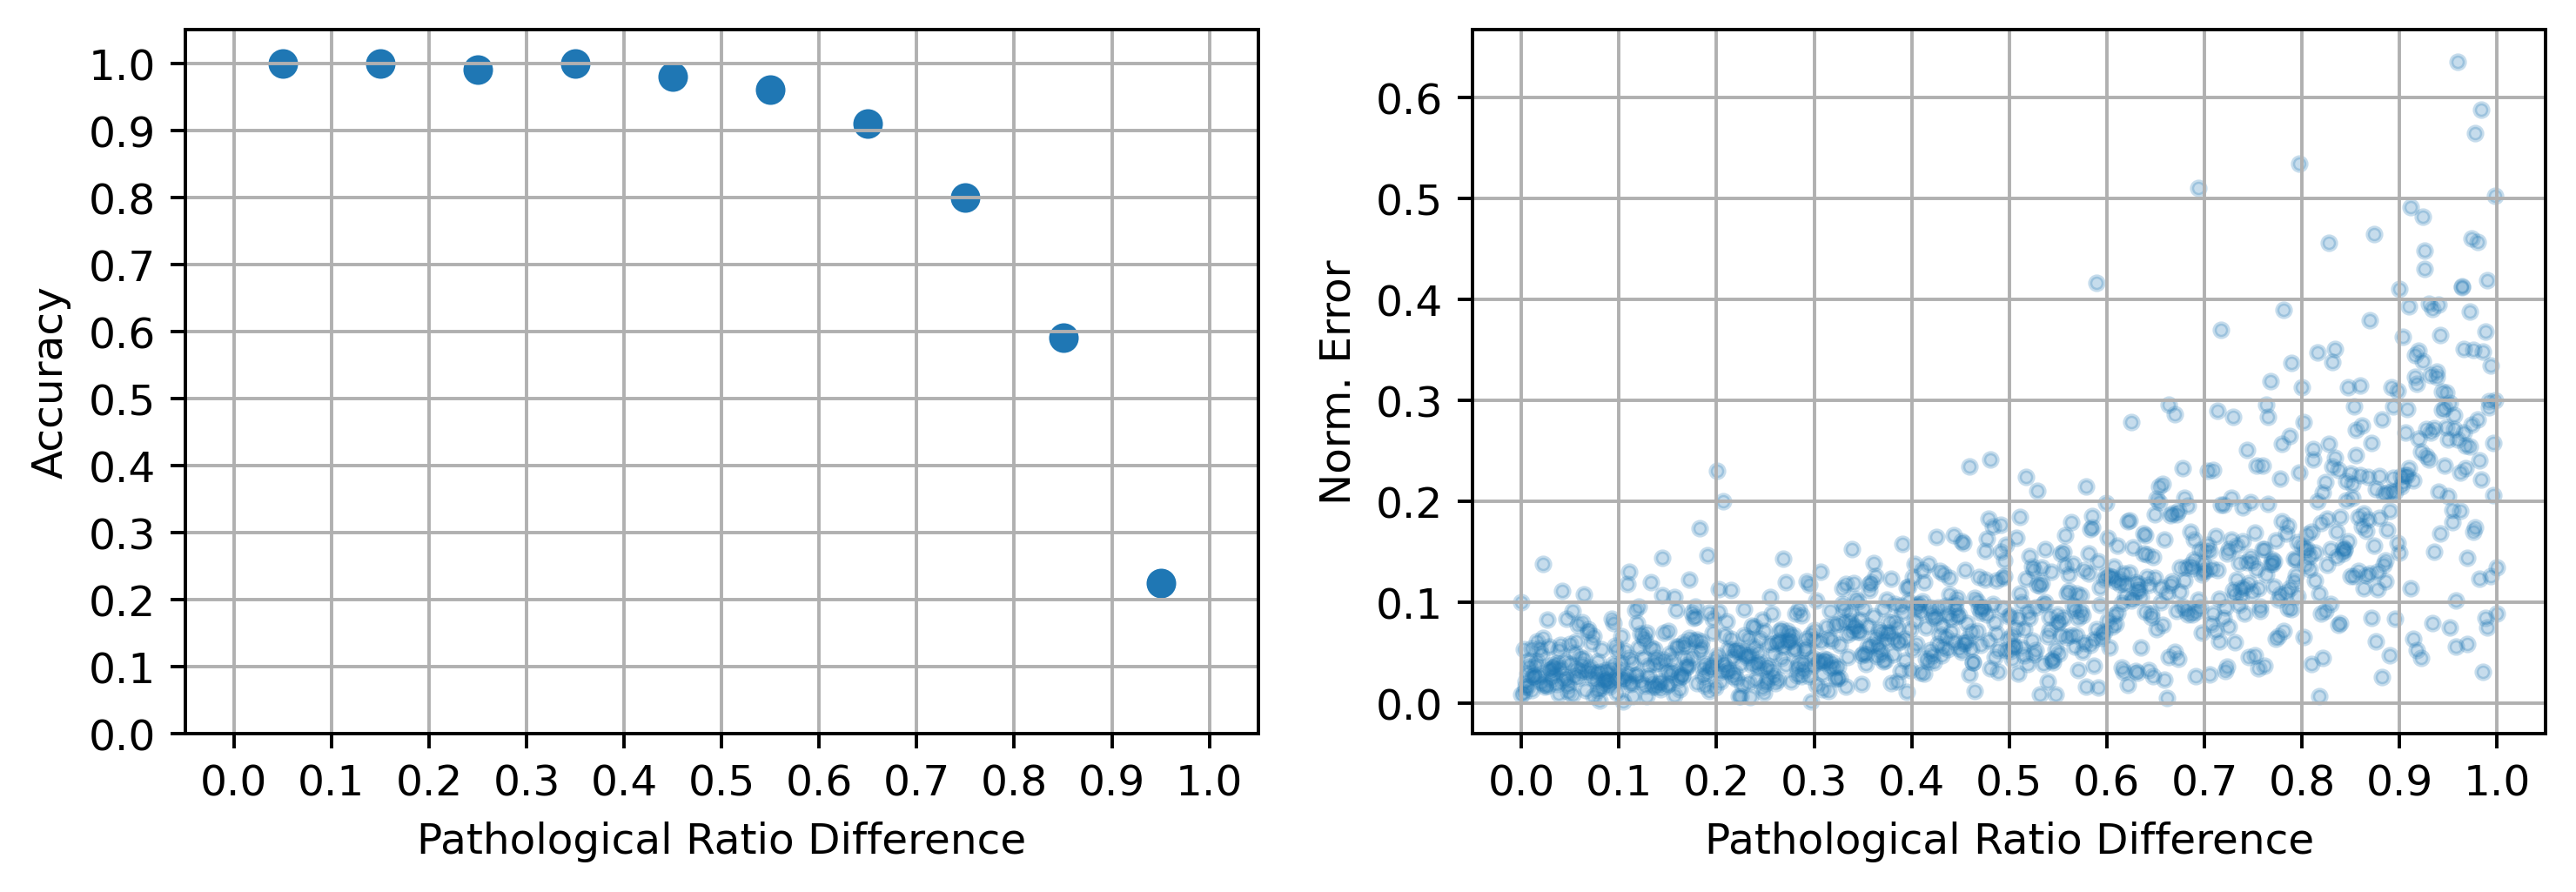

In [35]:
plt.figure(figsize=(10, 3), dpi=350)

plt.subplot(1,2,1)
accs = []
diffs = np.hstack([np.linspace(1, 0, 500), np.linspace(0, 1, 500)])
for i in np.linspace(0, 1, 11):
    if i==1.0:
        continue
    idx = (diffs>=i) & (diffs<i+0.1)
    accs.append(len(np.where(errors[idx]<=0.2)[0])/len(errors[idx]))
plt.scatter(np.linspace(0, 1, 11)[:-1]+0.05, accs)
plt.ylim([0, 1.05]);
plt.grid();
plt.xticks(np.linspace(0, 1, 11));
plt.yticks(np.linspace(0, 1, 11));
plt.xlabel('Pathological Ratio Difference')
plt.ylabel('Accuracy');
plt.xlim([-0.05, 1.05]);

plt.subplot(1,2,2)
plt.scatter(np.hstack([np.linspace(1, 0, 500), np.linspace(0, 1, 500)]), errors, alpha=0.25, s=10)
plt.xlabel('Pathological Ratio Difference')
plt.ylabel('Norm. Error');
plt.grid();
plt.xticks(np.linspace(0, 1, 11));
